<header style="background:#00233C;padding-left:20pt;padding-right:20pt;padding-top:20pt;padding-bottom:10pt;"><img id="Teradata-logo" src="https://storage.googleapis.com/clearscape_analytics_demo_data/DEMO_Logo/teradata.svg" alt="Teradata" style="width: 100px; height: auto; margin-top: 20pt;" align="right">
<p style="font-size:20px; color:#ffffff">UDW INNOVATION DAYS</p>
<p style="font-size:24px; color:#ffffff">KMeans</p>
</header>

### Use Case - Unsupervised Learning with K-means
1. Connect to Vantage
2. Create K-means model from randomized dataset
3. Visualize the results

#### Import teradataml package libraries

##### Install packages as needed
Note: You only need to run these once per package. The "!" allows you to run Linux script from the notebook cell. 

In [ ]:
#!pip install teradataml --user

In [2]:
# managing connection context
from teradataml import create_context, get_context, remove_context

# for teradataml DataFrame object
from teradataml import DataFrame, in_schema

# for copying pandas dataframe to SQL table
from teradataml import copy_to_sql

# dataframe manipulation methods and sql data types
from teradatasqlalchemy.types import *
from sqlalchemy.sql.expression import select, and_, or_, not_, extract, text, join, case as case_when
from sqlalchemy import func, sql, distinct

# teradataml utils
from teradataml import configure, db_drop_table, UtilFuncs, execute_sql

# Vantage Analytics Library (valib)
from teradataml.analytics.valib import *
from teradataml.analytics import Transformations as tf 

#### Import other helpful open source packages

In [3]:
# Open source packages

# hide passwords
import getpass as gp

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# system
from os.path import exists
import yaml, sys
from datetime import datetime as dt, timedelta
import math

# dataframes and matrices
import pandas as pd
import numpy as np

%matplotlib inline

##### Configure Display Options

In [4]:
plt.rcdefaults()
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (5, 3)
plt.rcParams['font.size'] = 8

### Connection Variables

##### Set User and Password Variables

In [5]:
user = gp.getpass("User")

User ········


In [6]:
password = gp.getpass("Password")

Password ········


##### Set Connection Variables

In [1]:
host = 'UDWTest'
logmech = 'LDAP'
defaultDB = 'INOUDWTRAINING2024' 

##### Create Context
See the PythonBasics-1-ConnectingToVantage Notebook for more information about contexts and garbage collection.  

In [7]:
td_context = create_context(host = host, 
                            username= user, 
                            password = password, 
                            logmech='LDAP', 
                            database=defaultDB)

/home/tlugtu/conda/lib/python3.10/site-packages/teradataml/context/context.py:484: TeradataMlRuntimeWarning: Warning: Password is URL encoded.
  warnings.warn("Warning: Password is URL encoded.", category=TeradataMlRuntimeWarning)


#### Set Vantage Analytics Library (VAL) database location

In [16]:
configure.val_install_location = 'val'

### Clustering with Fast K-means in VAL

#### Source Data

The source data is a randomly created dataframe with 3-dimensional data: (X, Y, Z).

In [12]:
# Setup the Teradata dataframe
df = DataFrame("coordinate3D")
df.sample(5)

id,X,Y,Z,sampleid
8255,0.8038804990021938,0.8482513293292233,0.8260659141657085,1
4468,0.0777582312415842,0.0235035070976136,0.0506308691695989,1
9955,0.7444861403797405,0.793295529926529,0.7688908351531347,1
2902,0.203137391460615,0.2148195584150756,0.2089784749378453,1
8265,0.8964440371131954,0.8680176988442668,0.8822308679787312,1


#### Visualize the source data

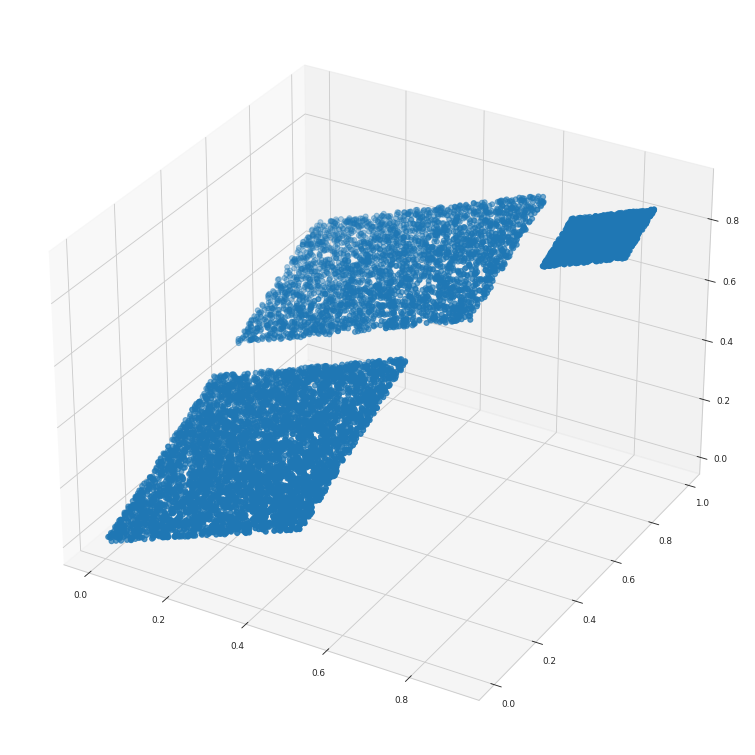

In [13]:
dfl = df.to_pandas()
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dfl.X.to_list(), dfl.Y.to_list(), dfl.Z.to_list())
plt.show()

#### K-means clustering: Model Creation
**DESCRIPTION:**
    The function performs fast K-Means clustering algorithm and returns cluster means
and averages. Specifically, the rows associated with positive cluster IDs in output
contain the average values of each of the clustered columns along with the count for
each cluster ID. The rows associated with negative cluster IDs contain the variance
of each of the clustered columns for each cluster ID.

In [18]:
cluster_model = valib.KMeans(data = df, 
                             columns = df.columns[1:4], 
                             centers = 3, 
                             operator_database = 'val')


##### Show the center point for each cluster

In [19]:
result = cluster_model.result
plot_ctr_df = result[result.clusterid>0].to_pandas().reset_index()

In [20]:
plot_ctr_df

,clusterid,cnt,X,Y,Z
0,3,4899,0.242296,0.243260,0.242778
1,2,2442,0.754322,0.828865,0.791594
2,1,2659,0.265987,0.774418,0.520202


##### Save the trained model into a table

In [21]:
result.to_sql(
    table_name = f"{user}_coordinate3D_kmean_mod",
    schema_name = defaultDB,
    if_exists = "replace",
    primary_index = 'clusterid'
)

##### K-means clustering: Cluster assignment
DESCRIPTION:
The function performs cluster prediction on test data based on the cluster model
generated by KMeans() VALIB function and generates a teradataml DataFrame containing
progress report with two columns, a timestamp, and a progress message.

In [23]:
cluster_agn = valib.KMeansPredict(data = df,
                                  model = cluster_model.result,
                                  cluster_column = "clusterid",
                                  index_columns = df.columns[0],
                                  operator_database = 'val',
                                  accumulate = df.columns[1:4]
                                 )


##### K-means clustering: Display the cluster assignment

In [24]:
plot_df = cluster_agn.result.to_pandas()
plot_df.head(5)

,clusterid,X,Y,Z
id,,,,
1853,3,0.170842,0.141914,0.156378
4177,3,0.231582,0.218916,0.225249
9010,2,0.881694,0.838279,0.859987
2669,3,0.469234,0.175465,0.322350
6339,1,0.242585,0.713917,0.478251


##### Save the clustering result to table

In [25]:
result = cluster_agn.result
result.to_sql(
    table_name = f"{user}_coordinate3D_kmean_agn",
    schema_name = defaultDB,
    if_exists = "replace",
    primary_index = df.columns[0]
)

## Vizualize the K-means result

In [26]:
plot_ctr_df

,clusterid,cnt,X,Y,Z
0,3,4899,0.242296,0.243260,0.242778
1,2,2442,0.754322,0.828865,0.791594
2,1,2659,0.265987,0.774418,0.520202


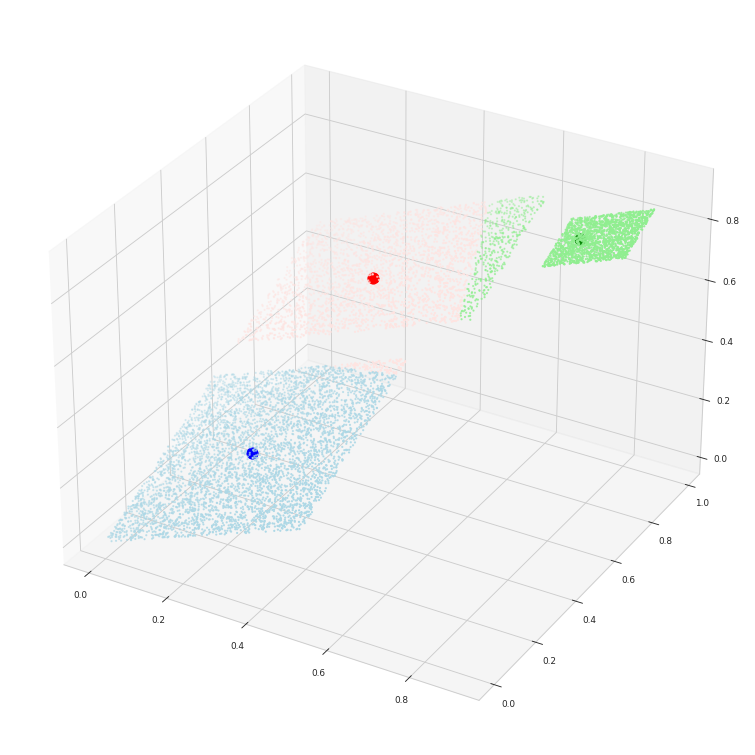

In [27]:
plt_col = [None,"mistyrose","lightgreen","lightblue"]
plt_colc = [None,"red","green","blue"]
fig = plt.figure(figsize=(12, 12), dpi=80)
ax = fig.add_subplot(111, projection='3d')

for i in range(1,4):
    tmp = plot_df[plot_df.clusterid==i]
    tmpc = plot_ctr_df[plot_ctr_df.clusterid==i]
    ax.scatter(tmp.X.to_list(), tmp.Y.to_list(), tmp.Z.to_list(), c= plt_col[i], s=1)
    ax.scatter(tmpc.X.to_list(), tmpc.Y.to_list(), tmpc.Z.to_list(), c= plt_colc[i], s=100)
plt.show()


#### Cleanup Tables

In [28]:
try:
    db_drop_table(f"{user}_coordinate3D_kmean_mod")
except: 
    pass

try:
    db_drop_table(f"{user}_coordinate3D_kmean_agn")
except: 
    pass

## Disconnect from Vantage

In [29]:
# One must run remove_context() to close the connection and garbage collect internally generated objects.
remove_context()

True

<span style="font-size:16px;">For online documentation on Teradata Vantage analytic functions, refer to the [Teradata Developer Portal](https://docs.teradata.com/) and search for phrases "Python User Guide" and "Python Function Reference".</span>